In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

In [2]:
train_days = 10
n_train = train_days*24*60*2

In [3]:
dataset = pd.read_csv('../wind_preprocessed.csv', header=0, index_col=0).query('day<14')
data = dataset[['speed_moveavg', 'power_moveavg']].rename(columns={'power_moveavg':'power', 'speed_moveavg':'speed'})
print(data.head())

                       speed    power
date                                 
2015-10-01 00:00:00  0.39627  0.38065
2015-10-01 00:00:30  0.39592  0.36943
2015-10-01 00:01:00  0.39538  0.38529
2015-10-01 00:01:30  0.39579  0.38892
2015-10-01 00:02:00  0.39627  0.41220


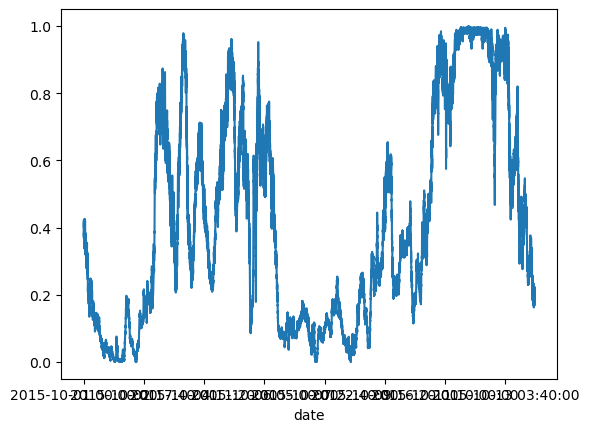

In [5]:
# 画时序图
power = data['power']
power.plot()
plt.show()

In [4]:
# 白噪声检验:LB&BP的p-value<0.05
acorr_ljungbox(power, lags = [6, 12],boxpierce=True)

NameError: name 'power' is not defined

In [5]:
# 平稳性检验
# 单位根ADF检验：p-value<0.05
adfResult = sm.tsa.stattools.adfuller(power)
output = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used",
                                         "Critical Value(1%)", "Critical Value(5%)", "Critical Value(10%)"],
                                  columns=['value'])
output['value']['Test Statistic Value'] = adfResult[0]
output['value']['p-value'] = adfResult[1]
output['value']['Lags Used'] = adfResult[2]
output['value']['Number of Observations Used'] = adfResult[3]
output['value']['Critical Value(1%)'] = adfResult[4]['1%']
output['value']['Critical Value(5%)'] = adfResult[4]['5%']
output['value']['Critical Value(10%)'] = adfResult[4]['10%']
print(output)

                                value
Test Statistic Value        -2.525867
p-value                      0.109307
Lags Used                          25
Number of Observations Used     37414
Critical Value(1%)          -3.430525
Critical Value(5%)          -2.861617
Critical Value(10%)         -2.566811


In [6]:
power_1 = power.diff(1).dropna()

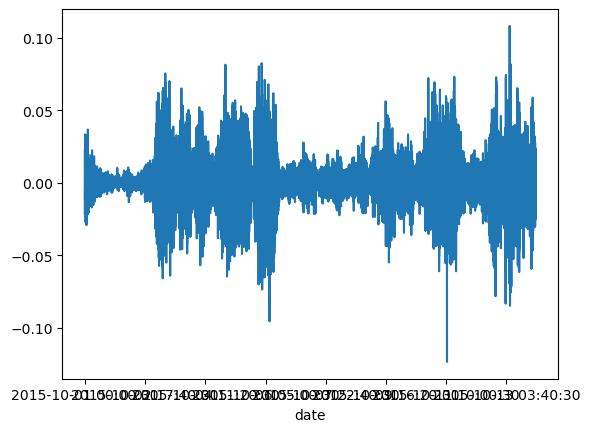

In [8]:
# 画时序图
power_1.plot()
plt.show()

In [7]:
# 平稳性检验
# 单位根ADF检验:p-value<0.05
adfResult = sm.tsa.stattools.adfuller(power_1)
output = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used",
                                         "Critical Value(1%)", "Critical Value(5%)", "Critical Value(10%)"],
                                  columns=['value'])
output['value']['Test Statistic Value'] = adfResult[0]
output['value']['p-value'] = adfResult[1]
output['value']['Lags Used'] = adfResult[2]
output['value']['Number of Observations Used'] = adfResult[3]
output['value']['Critical Value(1%)'] = adfResult[4]['1%']
output['value']['Critical Value(5%)'] = adfResult[4]['5%']
output['value']['Critical Value(10%)'] = adfResult[4]['10%']
print(output)

                                 value
Test Statistic Value        -36.006611
p-value                            0.0
Lags Used                           24
Number of Observations Used      37414
Critical Value(1%)           -3.430525
Critical Value(5%)           -2.861617
Critical Value(10%)          -2.566811


In [9]:
# 白噪声检验:LB&BP的p-value<0.05
acorr_ljungbox(power_1, lags = [6, 12],boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
6,4960.151627,0.0,4959.748089,0.0
12,4982.909500,0.0,4982.499371,0.0


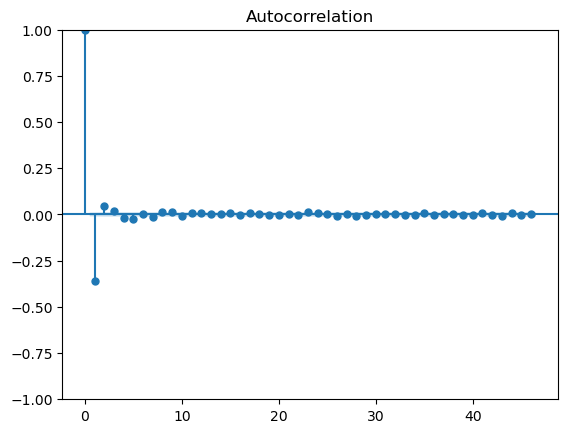

In [8]:
# 计算ACF
acf=plot_acf(power_1)
# plt.ylim(-0.2, 0.2)
plt.show()

In [11]:
q = 7

/home/ellahu/anaconda3/envs/bigdata/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


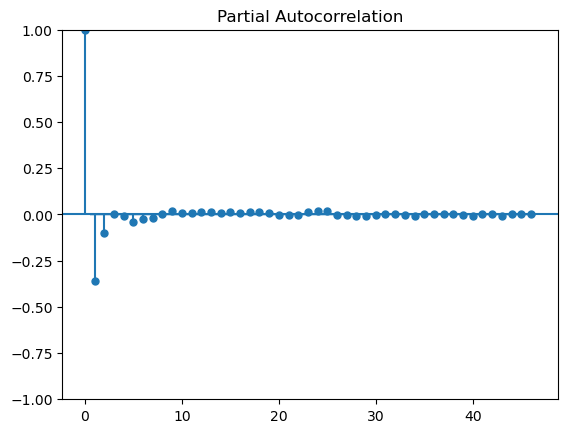

In [9]:
# 计算PACF
pacf=plot_pacf(power_1)
# plt.ylim(-0.1, 0.1)
plt.show()

In [10]:
p = 4

In [24]:
trend_evaluate = sm.tsa.arma_order_select_ic(power_1, ic=['aic', 'bic'], trend='n', max_ar=20,
                                            max_ma=5)
print('train AIC', trend_evaluate.aic_min_order)
print('train BIC', trend_evaluate.bic_min_order)

/home/ellahu/anaconda3/envs/bigdata/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ellahu/anaconda3/envs/bigdata/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ellahu/anaconda3/envs/bigdata/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ellahu/anaconda3/envs/bigdata/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ellahu/ana

In [12]:
# 划分训练集与测试集
train = power[:n_train]
test = power[n_train:n_train+60]
print(len(train), len(test), len(power))

28800 60 37440


In [13]:
model = sm.tsa.arima.ARIMA(train,order=(p,1,q))
arima_res=model.fit()
arima_res.summary()

/home/ellahu/anaconda3/envs/bigdata/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30S will be used.
  self._init_dates(dates, freq)
/home/ellahu/anaconda3/envs/bigdata/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30S will be used.
  self._init_dates(dates, freq)
/home/ellahu/anaconda3/envs/bigdata/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30S will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  power   No. Observations:                28800
Model:                 ARIMA(4, 1, 7)   Log Likelihood               89130.312
Date:                Thu, 12 Jan 2023   AIC                        -178236.625
Time:                        23:26:02   BIC                        -178137.407
Sample:                    10-01-2015   HQIC                       -178204.728
                         - 10-10-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2465      5.150      0.048      0.962      -9.847      10.340
ar.L2          0.0669      3.773      0.018      0.986      -7.329       7.463
ar.L3          0.0563      1.523      0.037      0.971      -2.928       3.041
ar.L4         -0.2071      1.280     -0.162      0.871      -2.716       2.302
ma.L1         -0.5642      5.150     -0.110      0.913     -10.658       9.529
ma.L2          0.0165      5.325      0.003      0.998     -10.420      10.453
ma.L3         -0.0284      2.222     -0.013      0.990      -4.383       4.327
ma.L4          0.1712      1.632      0.105      0.916      -3.028       3.370
ma.L5         -0.0897      0.672     -0.133      0.894      -1.407       1.228
ma.L6          0.0011      0.082      0.014      0.989      -0.160       0.162
ma.L7          0.0119      0.086      0.138      0.890      -0.157       0.181
sigma2         0.0001   5.44e-07    220.514      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             27777.15
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

60


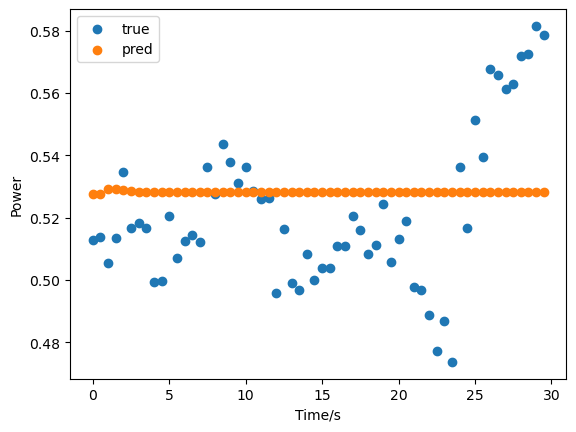

In [17]:
predict=arima_res.predict(test.index[0], test.index[-1])
x = np.arange(0, len(test)/2, 0.5)
plt.scatter(x, test.values)
plt.scatter(x, predict)
plt.legend(['true','pred'])

plt.ylabel('Power')
plt.xlabel('Time/s')
print(len(predict))